In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn

# machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv("train.csv")

df = df[['league','Date','HomeTeam','AwayTeam','FTR','HTHG','HTAG','HS','AS','HST','AST','AC','HF','AF','HC','HY','AY','HR','AR']]

data = df.copy()

In [3]:
#cleaning + Data transformatin

#League
#{'bundesliga': 0, 'la-liga': 1, 'ligue-1': 2, 'premier-league': 3, 'serie-a': 4}
League = sorted(data['league'].unique())
league_mapping = dict(zip(League, range(0, len(League) + 1 )))
data['league'] = data['league'].map(league_mapping).astype(int)

#dropping rows if FTR is nan
data = data.dropna(subset = ['FTR'])

#Full time result   ===> {'A': 0, 'D': 1, 'H': 2}
FTR = sorted(data['FTR'].unique())
FTR_mapping = dict(zip(FTR, range(0, len(FTR) + 1)))
data['FTR'] = data['FTR'].map(FTR_mapping).astype(int)

#HomeTeam   ===>
Team = sorted(data['HomeTeam'].unique())
Team_mapping = dict(zip(Team, range(0, len(Team) + 1)))
data['HomeTeam'] = data['HomeTeam'].map(Team_mapping).astype(int)

data['AwayTeam'] = data['AwayTeam'].map(Team_mapping).astype(int)


#Data rows with null values
data = data.dropna(subset = ['HTHG','HTAG','HS','AS','HST','AST','AC','HF','AF','HC','HY','AY','HR','AR'])
data[['HTHG','HTAG','HS','AS','HST','AST','AC','HF','AF','HC','HY','AY','HR','AR']] = data[['HTHG','HTAG','HS','AS','HST','AST','AC','HF','AF','HC','HY','AY','HR','AR']].astype(int)

#Date is not coorelated as winning of team is not determined by the current date
data = data.drop(['Date'],axis = 1)

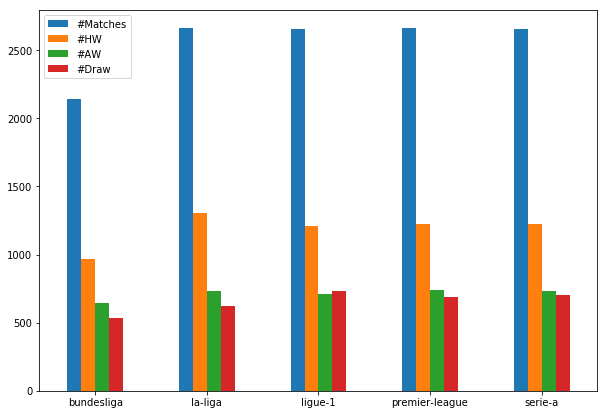

In [4]:
#Building Stats Data  --- To find if league is coorelated to Home Win Prediction
def league_count(x,y):
    return data['league'].loc[(data['league'] == x) & (data['FTR'] == y)].count()

#Stats
stats = pd.DataFrame()
stats['league'] = data['league'].unique()
stats['#HW'] = stats.apply(lambda row: league_count(row['league'],2), axis=1)
stats['#AW'] = stats.apply(lambda row: league_count(row['league'],0), axis=1)
stats['#Draw'] = stats.apply(lambda row: league_count(row['league'],1), axis=1)
stats['#Matches'] = stats['#Draw'] + stats['#HW'] + stats['#AW']

stats.index = League
stats = stats.drop(['league'],axis = 1)

stats['%HW'] = (stats['#HW']/stats['#Matches']) * 100
stats['%AW'] = (stats['#AW']/stats['#Matches']) * 100
stats['%Draw'] = (stats['#Draw']/stats['#Matches']) * 100

ax = stats[['#Matches','#HW','#AW','#Draw']].plot.bar(rot=0,figsize=(10,7))

In [5]:
stats

#HW  #AW  #Draw  #Matches        %HW        %AW      %Draw
bundesliga       965  644    533      2142  45.051354  30.065359  24.883287
la-liga         1303  733    624      2660  48.984962  27.556391  23.458647
ligue-1         1211  713    733      2657  45.577719  26.834776  27.587505
premier-league  1225  743    692      2660  46.052632  27.932331  26.015038
serie-a         1226  731    700      2657  46.142266  27.512232  26.345502

<b>Findings</b> <br>
1. Home Team winning likely - <b>46% </b> overall 
2. Away Team winning & Draw have similar percentage (<b>27.9% and 25.7% </b> overall)
3. In all the league above % Home Win is in similar brackets (League has negligible effects on home team winning)

C:\Users\I334934\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


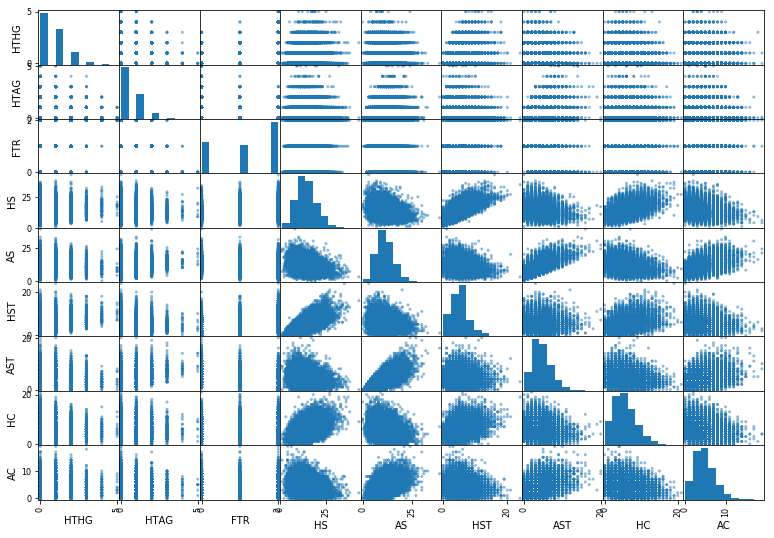

In [6]:
#Building Corelation Matrix
test = data[['HTHG','HTAG','FTR','HS','AS','HST','AST','HC','AC']].copy()
pd.scatter_matrix(test, figsize=(13, 9))
plt.show()
#Pearson corelation method (more neat and check HC's surprising negative corelation)
# More dark colours have negative corelation (-0.4)
# light colors indicate positive corelation (0.4 )
# 1 ==> full corelation
# towards 0 (eg 0.009) shows no corelation
test.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

As Expected<br>
Between HTHG, HS, HST shows positive correalation<br>
Between HTAG, AS, AST, AC shows positive correalation<br>
Between HTHG, HS, HST & HTAG, AS, AST shows negative correlation<br>

Surprisingly<br>
HC and HTHG shows negative correalation<br>
AC and HTAG shows negative correlation<br>

Points taken :- <br>
FTR has strong/moderate positive corelation with HTHG, HST and strong negative corelation with HTAG, HAT. <br>
FTR has slight positive corelation with HS and slight negative corelation with AS <br>
Suprisingly!!! HC and AC seems to have no/very light influence on FTR (May because of high values over HC & AC --> Shld plot and check .. ) <br>

C:\Users\I334934\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


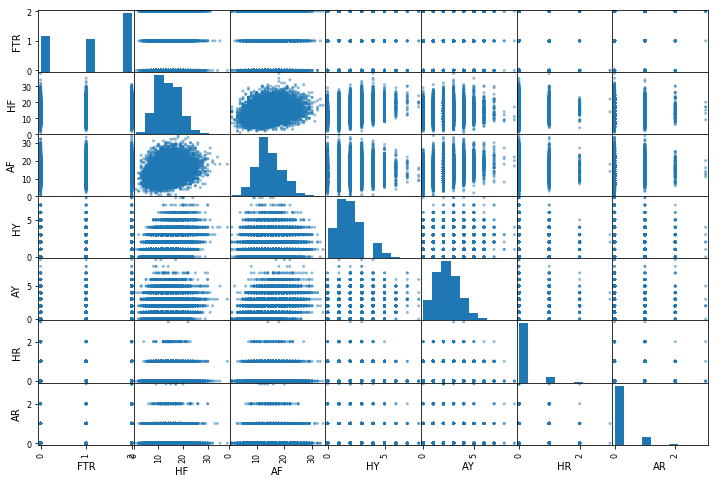

In [7]:
#Building 2 Corelation Matrix
test = data[['FTR','HF','AF','HY','AY','HR','AR']].copy()
pd.scatter_matrix(test, figsize=(12, 8))
plt.show()
test.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

Points taken :- <br>
HR and HY ==> +ve corelation<br>
AR and AY ==> +ve corelation<br>
FTR seems to be more influenced by HR,AR,HY than other fields<br>

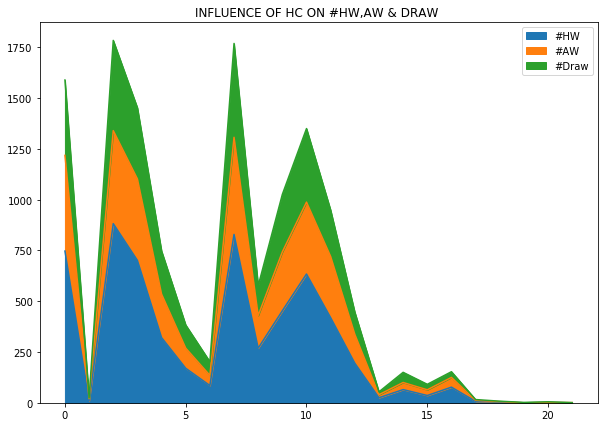

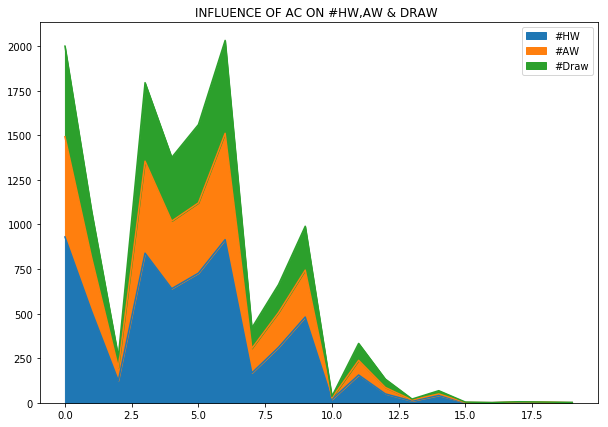

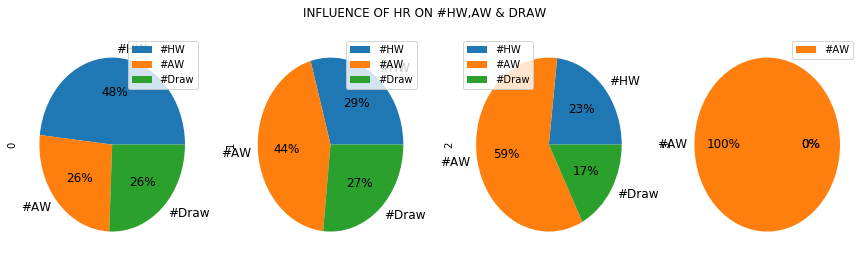

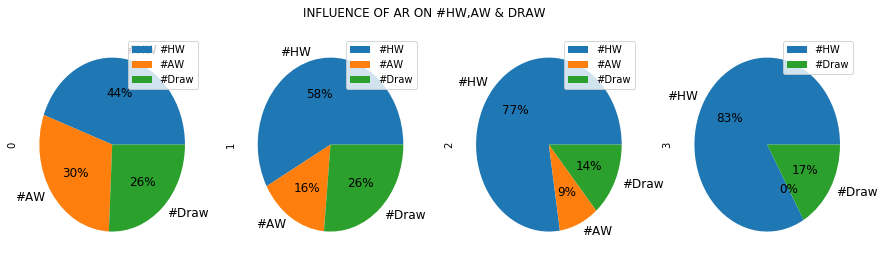

In [8]:
# About the corners and red cards
def find_count(col,x,y):
    return data['FTR'].loc[(data[col] == x) & (data['FTR'] == y)].count()
col = ['HC','AC','HR','AR']
test = list()
for i in range(0,len(col)):
    test.append("stat" + str(i))
    test[i] = pd.DataFrame()
    test[i][col[i]] = data[col[i]].unique()
    test[i]['#HW'] = test[i].apply(lambda row: find_count(col[i],row[col[i]],2), axis=1)
    test[i]['#AW'] = test[i].apply(lambda row: find_count(col[i],row[col[i]],0), axis=1)
    test[i]['#Draw'] = test[i].apply(lambda row: find_count(col[i],row[col[i]],1), axis=1)
    test[i] = test[i].drop([col[i]],axis = 1)
    title = "INFLUENCE OF " + col[i] + " ON #HW,AW & DRAW "
    if col[i] == 'HC' or col[i] == 'AC':
        ax = test[i][['#HW','#AW','#Draw']].plot.area(rot=0,figsize=(10,7),title = title)
    else:
        stat1 = test[i].transpose()
        ax = stat1.plot.pie(subplots=True,figsize=(15,4),title =title,fontsize = "12",autopct='%1.0f%%')

Decided Parameters for the trial run ----> HTHG, HTAG,HST,AST,HR,AR,HC,AC, <br>
dropping only HF,AF (Fouls) and HS,AS (as same correlation with HTHG), HY,AY (same correlation as HR & AR), League (not much relationship), date (Not much relationship)

In [9]:
def ml_models(train_X, val_X, train_y, val_y,name,model):
    score_list = []
    #print(name)
    #print("----------")
    model.fit(train_X,train_y)
    train_score = model.fit(train_X,train_y).score(train_X,train_y)
    #print("Training score is :",train_score )
    survival = model.predict(val_X)
    surv2 = survival.astype(int)
    test_score = accuracy_score(val_y,surv2)
    #print('Test Accuracy is ',test_score)
    score_list.append((name,train_score,test_score))
    return score_list,surv2

def ml_models_res(train_X, val_X, train_y,name,model):
    score_list = []
    model.fit(train_X,train_y)
    train_score = model.fit(train_X,train_y).score(train_X,train_y)
    survival = model.predict(val_X)
    surv2 = survival.astype(int)
    score_list.append((name,train_score))
    return score_list,surv2
    

def Histo_plot(score):
    ml = pd.DataFrame()
    ml['Name'] = [i[0][0] for i in score]
    ml["Train_score"] = [i[0][1] for i in score]
    ml['Test_score'] = [i[0][2] for i in score]
    ml.index = ml.Name
    ax = ml[['Train_score','Test_score']].plot.bar(rot=0,figsize=(10,10),yticks = np.arange(0.1, 1.1, 0.05))
    return ml

#Hyperparameter tuning + Grid search is done == >Optimal parameters are chosen
models = []
score_list_cross = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('DT', DecisionTreeClassifier(max_depth=8)))
models.append(('RF', RandomForestClassifier(n_estimators=100, max_depth = 9)))
models.append(('GB', GradientBoostingClassifier(n_estimators=100,max_depth= 2)))
models.append(('Ada', AdaBoostClassifier(learning_rate = 0.9, n_estimators = 150)))
models.append(('XGB', XGBClassifier()))
models.append(('ET', ExtraTreesClassifier(n_estimators=100, max_depth = 14)))
models.append(('SVM', SVC(C = 10, gamma = 0.01)))
models.append(('SVML', SVC(kernel="linear", C=0.020)))
models.append(('MLP', MLPClassifier(alpha=7)))

In [10]:
data1 = data.copy()

In [11]:
#First with all the columns
X_train = data1.drop(["FTR","HomeTeam","AwayTeam","league","HS","AS","AY","HY","HF","AF"],axis=1) 
Y_train = data1["FTR"]

#no of data - 9582
train_X, val_X, train_y, val_y = 8
(X_train, Y_train,random_state = 0)

score = []
for name,model in models:
    score.append(ml_models(train_X, val_X, train_y, val_y,name,model)[0])

C:\Users\I334934\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\I334934\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


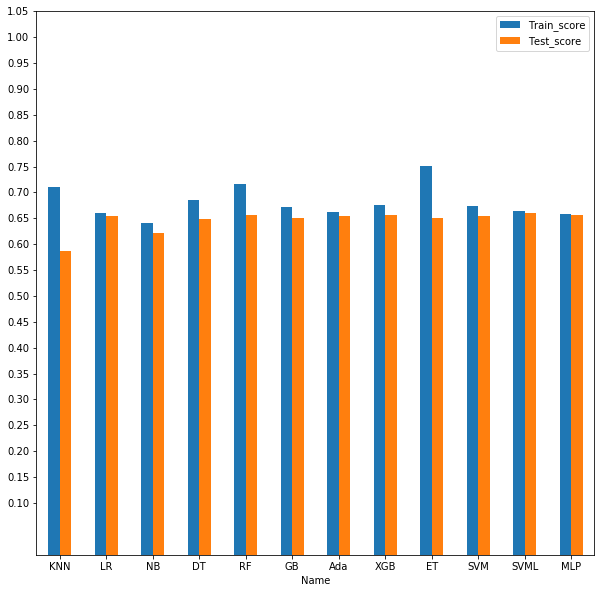

In [12]:
df_ml = Histo_plot(score)

In [13]:
df_ml

Name  Train_score  Test_score
Name                               
KNN    KNN     0.710186    0.587351
LR      LR     0.659361    0.655291
NB      NB     0.641411    0.622417
DT      DT     0.684617    0.647777
RF      RF     0.715717    0.657170
GB      GB     0.671154    0.651221
Ada    Ada     0.661970    0.654352
XGB    XGB     0.675851    0.656544
ET      ET     0.751409    0.650595
SVM    SVM     0.673972    0.654039
SVML  SVML     0.663223    0.660927
MLP    MLP     0.658631    0.656230

In [12]:
#Test.csv
#Mapping the values in the FTR dict(0,1,2) to there Keys(A,D,H)
def get_items(value):
    return list(FTR_mapping.keys())[list(FTR_mapping.values()).index(value)]


test_df = pd.read_csv("test.csv")
test = test_df.drop(["HomeTeam","AwayTeam","league","HS","AS","AY","HY","HF","AF","Date"],axis=1)
test = test.fillna(0)
score, FTR = ml_models_res(X_train,test,Y_train,"SVC-Linear",models[10][1]) # Using linear SVC
test['FTR'] = FTR
test_df['RES_FTR'] = test.apply(lambda row: get_items(row['FTR']),axis = 1)
test_df.to_csv("result_svc.csv")
print("Training accuracy using SVC-Linear",score)


Training accuracy using SVC-Linear [('SVC-Linear', 0.6622573575453976)]


In [514]:
'''
# Not required , so commenting out the code


#Checking with extra data now +6750
Ext_df = pd.read_csv("Extra data.csv")
Ext_df['FTR'] = Ext_df['FTR'].map(FTR_mapping).astype(int)
new_df = data.append(Ext_df)
new_df = new_df.dropna(subset = ['HTHG','HTAG','HS','AS','HST','AST','AC','HF','AF','HC','HY','AY','HR','AR'])
new_df[['HTHG','HTAG','HS','AS','HST','AST','AC','HF','AF','HC','HY','AY','HR','AR']] = new_df[['HTHG','HTAG','HS','AS','HST','AST','AC','HF','AF','HC','HY','AY','HR','AR']].astype(int)

#No of data - 19704
X_t = new_df[["AC","AR","AST","HC","HR","HST","HTAG","HTHG"]]
#X_t = new_df[["HTAG","HTHG","HR","AR","HY","AY","HST","AST","HS","AS"]]
Y_t = new_df["FTR"]
train_X1, val_X1, train_y1, val_y1 = train_test_split(X_t, Y_t,random_state = 0)

score = []
for name,model in models:
    score.append(ml_models(train_X1, val_X1, train_y1, val_y1,name,model))   
'''

'''
Grid Search already done ... Not intergrating now due to the time delay it creates!
from sklearn import svm, grid_search
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_
svc_param_selection(X_train, Y_train,4)

Output ==> {'C': 1, 'gamma': 0.001}
'''

{'C': 1, 'gamma': 0.001}